# Proyecto SDE Lotka Volterra

Integrantes: Javier Cruz & Bonnie Lagos

Docente a Cargo: Álvaro Márquez

## Librerias

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.autograd as autograd

## Código

Usando dispositivo: cpu
Puntos de equilibrio: x1_eq = 0.7500, x2_eq = 0.6250
Comenzando entrenamiento...
Epoch 0: Loss = 2.256534, Drift Loss = 1.602129, Diffusion Loss = 0.654068
Epoch 500: Loss = 0.003564, Drift Loss = 0.002775, Diffusion Loss = 0.000629
Epoch 1000: Loss = 0.001236, Drift Loss = 0.001054, Diffusion Loss = 0.000154
Epoch 1500: Loss = 0.000992, Drift Loss = 0.000105, Diffusion Loss = 0.000885
Epoch 2000: Loss = 0.000059, Drift Loss = 0.000049, Diffusion Loss = 0.000009
Epoch 2500: Loss = 0.000043, Drift Loss = 0.000033, Diffusion Loss = 0.000009
Epoch 3000: Loss = 0.000369, Drift Loss = 0.000334, Diffusion Loss = 0.000012
Epoch 3500: Loss = 0.000099, Drift Loss = 0.000081, Diffusion Loss = 0.000014
Epoch 4000: Loss = 0.000016, Drift Loss = 0.000010, Diffusion Loss = 0.000005
Epoch 4500: Loss = 0.000060, Drift Loss = 0.000049, Diffusion Loss = 0.000008

Entrenamiento completado!
Visualizando resultados...


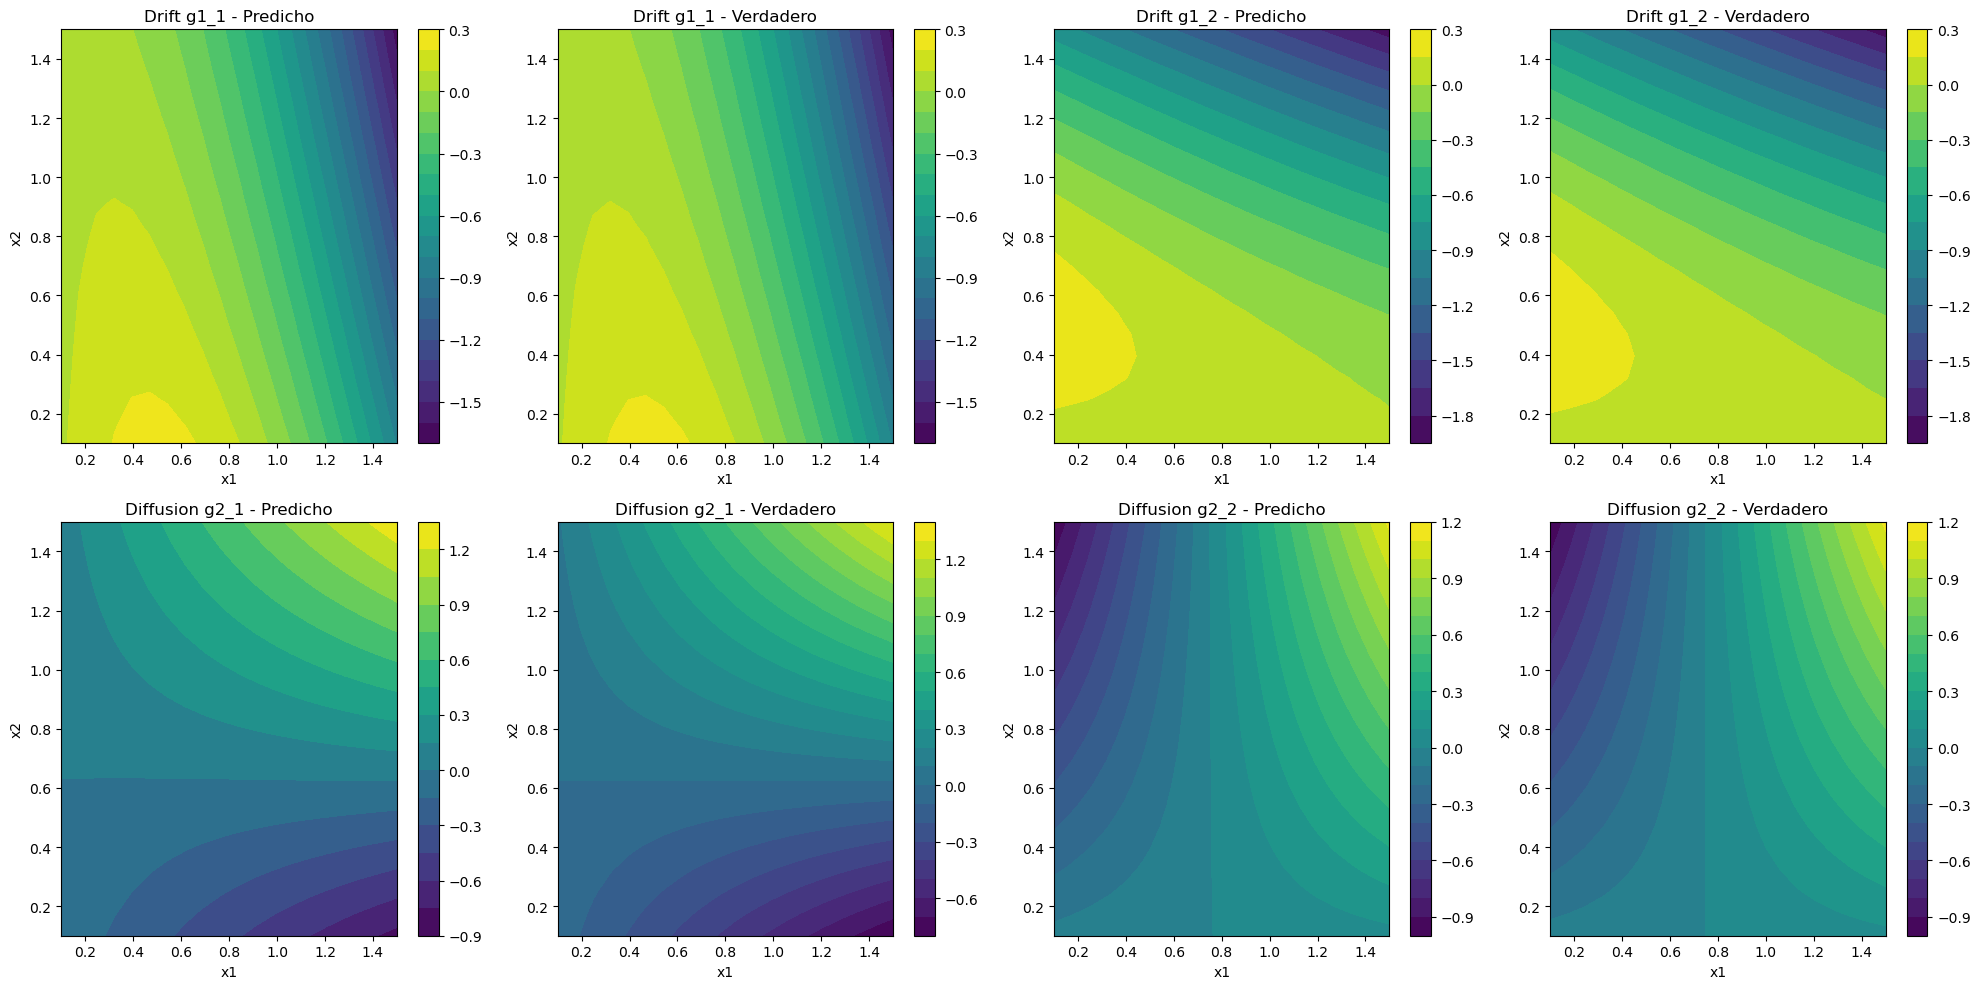

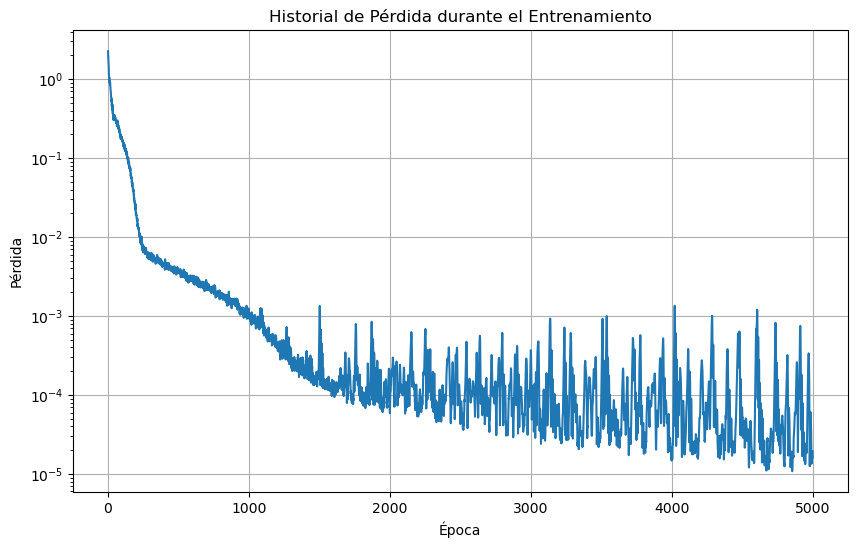


Evaluación en el punto de equilibrio (0.7500, 0.6250):
Drift predicho en equilibrio: [[-0.000421   -0.00198032]]
Diffusion predicho en equilibrio: [[-0.00429527 -0.0038982 ]]
Drift verdadero en equilibrio: [[0. 0.]]
Diffusion verdadero en equilibrio: [[0. 0.]]


In [3]:
# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Parámetros del sistema
k1 = 0.4
k2 = 0.5

# Puntos de equilibrio
x1_eq = (1 - k1) / (1 - k1 * k2)
x2_eq = (1 - k2) / (1 - k1 * k2)

print(f"Puntos de equilibrio: x1_eq = {x1_eq:.4f}, x2_eq = {x2_eq:.4f}")

# Definición de las redes neuronales
class DriftNetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dim=64, num_layers=3):
        super(DriftNetwork, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class DiffusionNetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dim=64, num_layers=3):
        super(DiffusionNetwork, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Clase principal para PINN-SDE
class LotkaVolterraPINN:
    def __init__(self):
        self.drift_net = DriftNetwork().to(device)
        self.diffusion_net = DiffusionNetwork().to(device)
        
        # Parámetros conocidos
        self.k1 = k1
        self.k2 = k2
        self.x1_eq = x1_eq
        self.x2_eq = x2_eq
        
        # Optimizadores
        self.optimizer = Adam(
            list(self.drift_net.parameters()) + list(self.diffusion_net.parameters()),
            lr=1e-3
        )
        
        # Historial de pérdidas
        self.loss_history = []
    
    def true_drift(self, x):
        """Función de drift verdadera para validación"""
        x1, x2 = x[:, 0:1], x[:, 1:2]
        g1_1 = x1 * (1 - x1 - self.k1 * x2)
        g1_2 = x2 * (1 - x2 - self.k2 * x1)
        return torch.cat([g1_1, g1_2], dim=1)
    
    def true_diffusion(self, x):
        """Función de difusión verdadera para validación"""
        x1, x2 = x[:, 0:1], x[:, 1:2]
        g2_1 = x1 * (x2 - self.x2_eq)
        g2_2 = x2 * (x1 - self.x1_eq)
        return torch.cat([g2_1, g2_2], dim=1)
    
    def generate_training_data(self, num_points=1000, t_range=(0, 5)):
        """Genera datos de entrenamiento en el espacio de estado"""
        # Puntos aleatorios en el espacio de estado (x1, x2)
        x1 = torch.rand(num_points, 1, device=device) * 2.0  # x1 ∈ [0, 2]
        x2 = torch.rand(num_points, 1, device=device) * 2.0  # x2 ∈ [0, 2]
        
        # Tiempo aleatorio
        t = torch.rand(num_points, 1, device=device) * (t_range[1] - t_range[0]) + t_range[0]
        
        # Datos de entrada completos
        X = torch.cat([x1, x2, t], dim=1)
        
        return X
    
    def physics_loss(self, X):
        """Calcula la pérdida basada en la física del SDE"""
        x1 = X[:, 0:1]
        x2 = X[:, 1:2]
        t = X[:, 2:3]
        
        # Entrada para las redes (solo coordenadas espaciales)
        x_spatial = torch.cat([x1, x2], dim=1)
        
        # Predicciones de las redes
        g1_pred = self.drift_net(x_spatial)
        g2_pred = self.diffusion_net(x_spatial)
        
        # Valores verdaderos (para comparación)
        g1_true = self.true_drift(x_spatial)
        g2_true = self.true_diffusion(x_spatial)
        
        # Pérdida MSE para drift y diffusion
        loss_drift = torch.mean((g1_pred - g1_true) ** 2)
        loss_diffusion = torch.mean((g2_pred - g2_true) ** 2)
        
        # Pérdida adicional: equilibrio debe ser punto fijo
        x_eq = torch.tensor([[self.x1_eq, self.x2_eq]], device=device)
        drift_at_eq = self.drift_net(x_eq)
        loss_equilibrium = torch.mean(drift_at_eq ** 2)
        
        # Pérdida total
        total_loss = loss_drift + loss_diffusion + 0.1 * loss_equilibrium
        
        return total_loss, loss_drift, loss_diffusion
    
    def train(self, num_epochs=5000, num_points=1000):
        """Entrena el modelo"""
        self.drift_net.train()
        self.diffusion_net.train()
        
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            
            # Generar nuevos datos de entrenamiento
            X_train = self.generate_training_data(num_points)
            
            # Calcular pérdida
            total_loss, loss_drift, loss_diffusion = self.physics_loss(X_train)
            
            # Backpropagation
            total_loss.backward()
            self.optimizer.step()
            
            # Guardar historial
            self.loss_history.append(total_loss.item())
            
            if epoch % 500 == 0:
                print(f"Epoch {epoch}: Loss = {total_loss.item():.6f}, "
                      f"Drift Loss = {loss_drift.item():.6f}, "
                      f"Diffusion Loss = {loss_diffusion.item():.6f}")
    
    def predict(self, x1, x2):
        """Predice drift y diffusion para puntos dados"""
        self.drift_net.eval()
        self.diffusion_net.eval()
        
        with torch.no_grad():
            x = torch.tensor(np.column_stack([x1, x2]), dtype=torch.float32, device=device)
            g1_pred = self.drift_net(x).cpu().numpy()
            g2_pred = self.diffusion_net(x).cpu().numpy()
            
            # Valores verdaderos para comparación
            g1_true = self.true_drift(x).cpu().numpy()
            g2_true = self.true_diffusion(x).cpu().numpy()
            
        return g1_pred, g2_pred, g1_true, g2_true
    
    def plot_results(self):
        """Visualiza los resultados"""
        # Crear malla para visualización
        x1_vals = np.linspace(0.1, 1.5, 20)
        x2_vals = np.linspace(0.1, 1.5, 20)
        X1, X2 = np.meshgrid(x1_vals, x2_vals)
        
        # Predecir en la malla
        g1_pred, g2_pred, g1_true, g2_true = self.predict(X1.flatten(), X2.flatten())
        
        # Preparar datos para plotting
        g1_pred_1 = g1_pred[:, 0].reshape(X1.shape)
        g1_pred_2 = g1_pred[:, 1].reshape(X1.shape)
        g2_pred_1 = g2_pred[:, 0].reshape(X1.shape)
        g2_pred_2 = g2_pred[:, 1].reshape(X1.shape)
        
        g1_true_1 = g1_true[:, 0].reshape(X1.shape)
        g1_true_2 = g1_true[:, 1].reshape(X1.shape)
        g2_true_1 = g2_true[:, 0].reshape(X1.shape)
        g2_true_2 = g2_true[:, 1].reshape(X1.shape)
        
        # Plotting
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        # Drift component 1
        im1 = axes[0,0].contourf(X1, X2, g1_pred_1, levels=20)
        axes[0,0].set_title('Drift g1_1 - Predicho')
        axes[0,0].set_xlabel('x1')
        axes[0,0].set_ylabel('x2')
        plt.colorbar(im1, ax=axes[0,0])
        
        im2 = axes[0,1].contourf(X1, X2, g1_true_1, levels=20)
        axes[0,1].set_title('Drift g1_1 - Verdadero')
        axes[0,1].set_xlabel('x1')
        axes[0,1].set_ylabel('x2')
        plt.colorbar(im2, ax=axes[0,1])
        
        # Drift component 2
        im3 = axes[0,2].contourf(X1, X2, g1_pred_2, levels=20)
        axes[0,2].set_title('Drift g1_2 - Predicho')
        axes[0,2].set_xlabel('x1')
        axes[0,2].set_ylabel('x2')
        plt.colorbar(im3, ax=axes[0,2])
        
        im4 = axes[0,3].contourf(X1, X2, g1_true_2, levels=20)
        axes[0,3].set_title('Drift g1_2 - Verdadero')
        axes[0,3].set_xlabel('x1')
        axes[0,3].set_ylabel('x2')
        plt.colorbar(im4, ax=axes[0,3])
        
        # Diffusion component 1
        im5 = axes[1,0].contourf(X1, X2, g2_pred_1, levels=20)
        axes[1,0].set_title('Diffusion g2_1 - Predicho')
        axes[1,0].set_xlabel('x1')
        axes[1,0].set_ylabel('x2')
        plt.colorbar(im5, ax=axes[1,0])
        
        im6 = axes[1,1].contourf(X1, X2, g2_true_1, levels=20)
        axes[1,1].set_title('Diffusion g2_1 - Verdadero')
        axes[1,1].set_xlabel('x1')
        axes[1,1].set_ylabel('x2')
        plt.colorbar(im6, ax=axes[1,1])
        
        # Diffusion component 2
        im7 = axes[1,2].contourf(X1, X2, g2_pred_2, levels=20)
        axes[1,2].set_title('Diffusion g2_2 - Predicho')
        axes[1,2].set_xlabel('x1')
        axes[1,2].set_ylabel('x2')
        plt.colorbar(im7, ax=axes[1,2])
        
        im8 = axes[1,3].contourf(X1, X2, g2_true_2, levels=20)
        axes[1,3].set_title('Diffusion g2_2 - Verdadero')
        axes[1,3].set_xlabel('x1')
        axes[1,3].set_ylabel('x2')
        plt.colorbar(im8, ax=axes[1,3])
        
        plt.tight_layout()
        plt.show()
        
        # Plot pérdida
        plt.figure(figsize=(10, 6))
        plt.semilogy(self.loss_history)
        plt.title('Historial de Pérdida durante el Entrenamiento')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.grid(True)
        plt.show()

# Entrenar el modelo
def main():
    # Inicializar y entrenar el modelo
    pinn_model = LotkaVolterraPINN()
    
    print("Comenzando entrenamiento...")
    pinn_model.train(num_epochs=5000, num_points=1000)
    
    print("\nEntrenamiento completado!")
    print("Visualizando resultados...")
    
    # Visualizar resultados
    pinn_model.plot_results()
    
    # Evaluar en el punto de equilibrio
    print(f"\nEvaluación en el punto de equilibrio ({x1_eq:.4f}, {x2_eq:.4f}):")
    x_test = torch.tensor([[x1_eq, x2_eq]], device=device)
    
    pinn_model.drift_net.eval()
    pinn_model.diffusion_net.eval()
    
    with torch.no_grad():
        drift_at_eq = pinn_model.drift_net(x_test)
        diffusion_at_eq = pinn_model.diffusion_net(x_test)
        
        print(f"Drift predicho en equilibrio: {drift_at_eq.cpu().numpy()}")
        print(f"Diffusion predicho en equilibrio: {diffusion_at_eq.cpu().numpy()}")
        print(f"Drift verdadero en equilibrio: {pinn_model.true_drift(x_test).cpu().numpy()}")
        print(f"Diffusion verdadero en equilibrio: {pinn_model.true_diffusion(x_test).cpu().numpy()}")

if __name__ == "__main__":
    main()